## Data Loading

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# --- Configuration ---
DATA_PATH = 'C:/3rd/311/PJ Xraty/chest_xray/Data'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SHUFFLE_TRAIN = True
SHUFFLE_VAL = False
NUM_EPOCHS = 800
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#ตั้งค่าพารามิเตอร์พื้นฐานสำหรับการเทรนโมเดล เช่น ที่อยู่ข้อมูล ขนาดภาพ การสุ่มข้อมูล รอบการเทรน และอุปกรณ์ที่ใช้ประมวลผล

In [ ]:
# --- Helper Functions ---
def create_dataframe(data_dir, subset):
    normal_dir = os.path.join(data_dir, subset, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, subset, 'PNEUMONIA')

    normal_paths = [os.path.join(normal_dir, file) for file in os.listdir(normal_dir)]
    pneumonia_paths = [os.path.join(pneumonia_dir, file) for file in os.listdir(pneumonia_dir)]

    normal_labels = [0] * len(normal_paths)
    pneumonia_labels = [1] * len(pneumonia_paths)

    paths = normal_paths + pneumonia_paths
    labels = normal_labels + pneumonia_labels

    return pd.DataFrame({'path': paths, 'label': labels})

#รวม path ของภาพ “NORMAL” และ “PNEUMONIA” พร้อมสร้าง label (0,1) แล้วคืนค่าเป็น DataFrame สำหรับใช้เทรนโมเดล

In [ ]:
# --- Dataset Class ---
class XRayDataset(Dataset):
    def __init__(self, dataframe, image_size, transform=None):
        self.dataframe = dataframe
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['path'][idx]
        image = Image.open(image_path).convert('L')  # Grayscale conversion
        label = self.dataframe['label'][idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
#สร้าง dataset สำหรับโหลดภาพและ label โดยแปลงภาพเป็นขาวดำ (grayscale) และปรับขนาดภาพตามที่กำหนด

## EDA

Train set class distribution:
label
1    3875
0    1341
Name: count, dtype: int64

Validation set class distribution:
label
0    8
1    8
Name: count, dtype: int64

Test set class distribution:
label
1    390
0    234
Name: count, dtype: int64



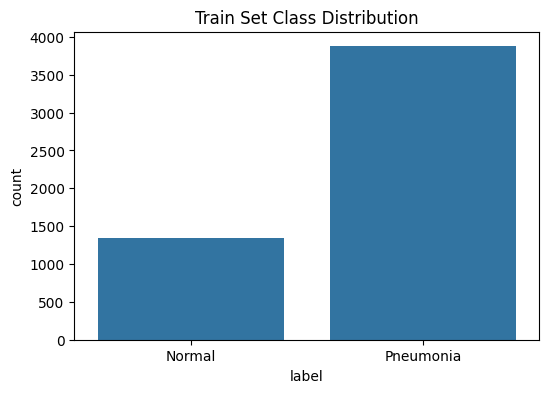

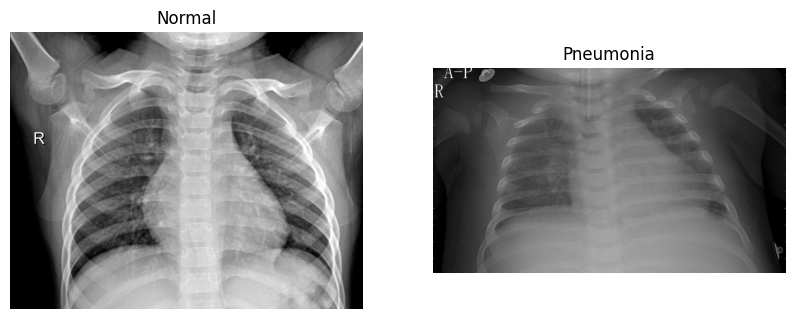

Train set missing values:
path     0
label    0
dtype: int64
Train set duplicate rows: 0

Validation set missing values:
path     0
label    0
dtype: int64
Validation set duplicate rows: 0

Test set missing values:
path     0
label    0
dtype: int64
Test set duplicate rows: 0


Train set image sizes:
Image size statistics:
             width       height
count  5216.000000  5216.000000
mean   1320.610813   968.074770
std     355.298743   378.855691
min     384.000000   127.000000
25%    1056.000000   688.000000
50%    1284.000000   888.000000
75%    1552.000000  1187.750000
max    2916.000000  2663.000000

Validation set image sizes:
Image size statistics:
             width       height
count    16.000000    16.000000
mean   1348.250000  1002.937500
std     256.771624   262.954868
min     968.000000   592.000000
25%    1182.000000   826.000000
50%    1280.000000   996.000000
75%    1581.000000  1152.250000
max    1776.000000  1416.000000

Test set image sizes:
Image size statistics:
 

In [ ]:
# --- EDA: Exploratory Data Analysis for Chest X-ray Dataset ---

# 1. Load DataFrames (run this if not already done)
train_df = create_dataframe(DATA_PATH, 'train')
val_df = create_dataframe(DATA_PATH, 'val')
test_df = create_dataframe(DATA_PATH, 'test')

# 2. Check class distribution for each split
for name, df in zip(['Train', 'Validation', 'Test'], [train_df, val_df, test_df]):
    print(f"{name} set class distribution:")
    print(df['label'].value_counts())
    print()

# 3. Visualize class distribution for train set
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title('Train Set Class Distribution')
plt.xticks([0,1], ['Normal', 'Pneumonia'])
plt.show()

# 4. Show sample images from each class
from PIL import Image

def show_samples(df, n=2):
    fig, axes = plt.subplots(1, n, figsize=(10,5))
    for i, label in enumerate([0, 1]):
        sample = df[df['label'] == label].sample(1)
        img = Image.open(sample['path'].values[0])
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title('Normal' if label==0 else 'Pneumonia')
        axes[i].axis('off')
    plt.show()

show_samples(train_df)

# 5. Check for missing and duplicate data in all splits
for name, df in zip(['Train', 'Validation', 'Test'], [train_df, val_df, test_df]):
    print(f"{name} set missing values:\n{df.isnull().sum()}")
    print(f"{name} set duplicate rows: {df.duplicated().sum()}\n")

# 6. Check image sizes and resolutions
def check_image_sizes(df):
    widths = []
    heights = []
    for path in df['path']:
        try:
            img = Image.open(path)
            width, height = img.size
            widths.append(width)
            heights.append(height)
        except Exception as e:
            print(f"Error opening image {path}: {e}")
            widths.append(None)
            heights.append(None)
    df['width'] = widths
    df['height'] = heights
    print("Image size statistics:")
    print(df[['width', 'height']].describe())

for name, df in zip(['Train', 'Validation', 'Test'], [train_df, val_df, test_df]):
    print(f"\n{name} set image sizes:")
    check_image_sizes(df)

## Model Definition (CNN from Scratch)

In [ ]:
import torch.nn as nn

class AlexNetGrayscale(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNetGrayscale, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),  # Input channels: 1 for grayscale
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
#AlexNet ที่ปรับให้รับภาพขาวดำ (1 channel) โดยมีเลเยอร์คอนโวลูชันและเลเยอร์เชื่อมต่อเต็มรูปแบบตามสถาปัตยกรรม AlexNet ดั้งเดิม

In [ ]:
# --- Transformations ---
data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

# --- Data Loading ---
train_df = create_dataframe(DATA_PATH, 'train')
val_df = create_dataframe(DATA_PATH, 'val')
test_df = create_dataframe(DATA_PATH, 'test')

train_dataset = XRayDataset(train_df, IMAGE_SIZE, data_transform)
val_dataset = XRayDataset(val_df, IMAGE_SIZE, data_transform)
test_dataset = XRayDataset(test_df, IMAGE_SIZE, data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_VAL)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_VAL)

#โหลดข้อมูลภาพและ label โดยใช้ DataLoader เพื่อเตรียมข้อมูลสำหรับการเทรนและการทดสอบโมเดล

## Training Loop

In [ ]:
def calculate_accuracy(outputs, labels):
    """Calculates the accuracy given model outputs and labels."""
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [ ]:
model = AlexNetGrayscale(num_classes=2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        running_corrects += (predicted == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = running_corrects / total_train
    train_loss_history.append(epoch_loss)
    train_accuracy_history.append(epoch_acc)

    # --- Validation Loop ---
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_corrects += (predicted == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = val_loss / total_val
    epoch_val_acc = val_corrects / total_val
    val_loss_history.append(epoch_val_loss)
    val_accuracy_history.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


KeyboardInterrupt: 

## Plotting

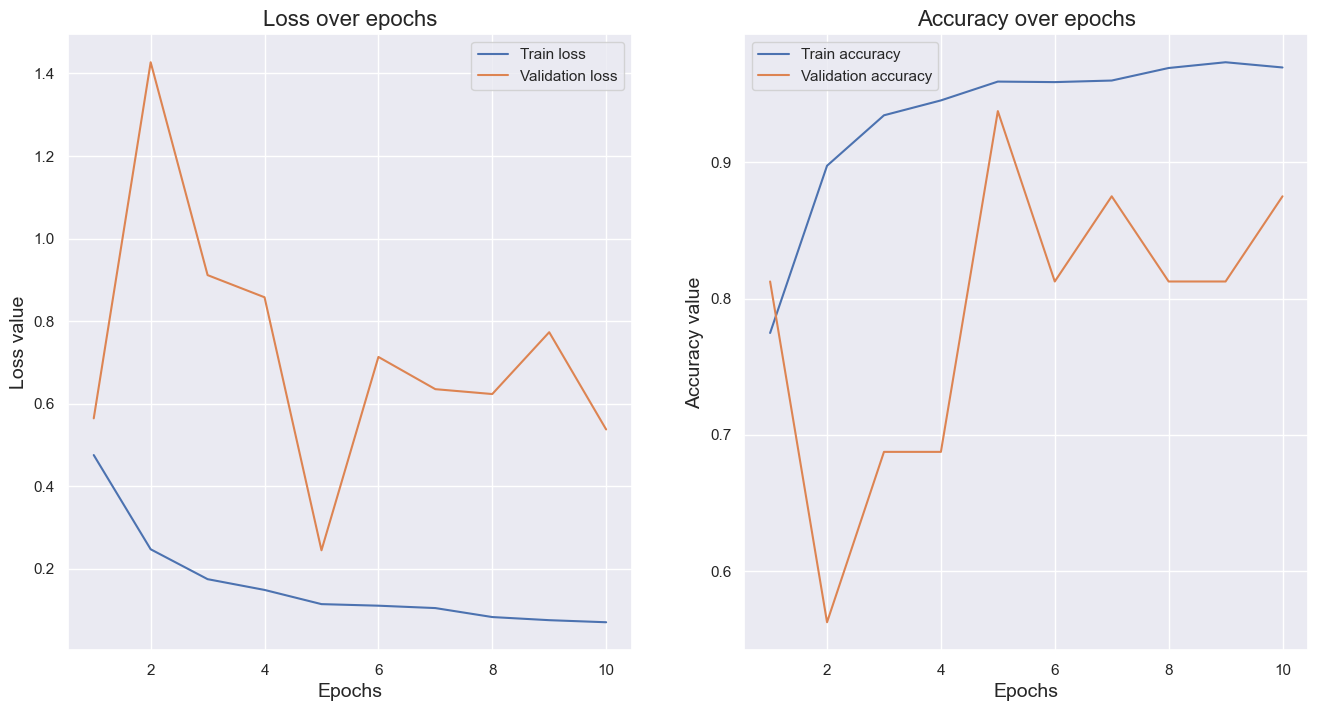

In [ ]:
def plot_training_history(train_loss, val_loss, train_accuracy, val_accuracy, num_epochs):
    """Plots the training and validation loss and accuracy over epochs."""

    sns.set()  # Apply seaborn's default style

    epochs = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(16, 8))  # Adjust figure size

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Loss over epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss value', fontsize=14)
    plt.legend()

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Train accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    plt.title('Accuracy over epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy value', fontsize=14)
    plt.legend()

    plt.show()

plot_training_history(train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, NUM_EPOCHS)

## Test

In [ ]:
# --- Prediction on Test Data ---
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 72.92%
